# **Project Machine Learning #1 - PUTRA ADE NIRADA**

#Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

%matplotlib inline

#Load Dataset

In [2]:
df = pd.read_csv("Default_Fin.csv")

In [3]:
df.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          10000 non-null  int64  
 1   Employed       10000 non-null  int64  
 2   Bank Balance   10000 non-null  float64
 3   Annual Salary  10000 non-null  float64
 4   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


#**Exploratory Data Analysis (EDA)**

##Analisis Deskriptif

In [5]:
df.describe(include='all')

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,0.705600,10024.498524,402203.782224,0.033300
std,2886.89568,0.455795,5804.579486,160039.674988,0.179428
min,1.00000,0.000000,0.000000,9263.640000,0.000000
25%,2500.75000,0.000000,5780.790000,256085.520000,0.000000
50%,5000.50000,1.000000,9883.620000,414631.740000,0.000000
75%,7500.25000,1.000000,13995.660000,525692.760000,0.000000
max,10000.00000,1.000000,31851.840000,882650.760000,1.000000


In [6]:
df.isnull().sum()

,0
Index,0
Employed,0
Bank Balance,0
Annual Salary,0
Defaulted?,0


In [7]:
duplicated  = df.duplicated().sum()
print(f"Data Duplicat: {duplicated}")

Data Duplicat: 0


##Outliers

###Identifikasi Awal

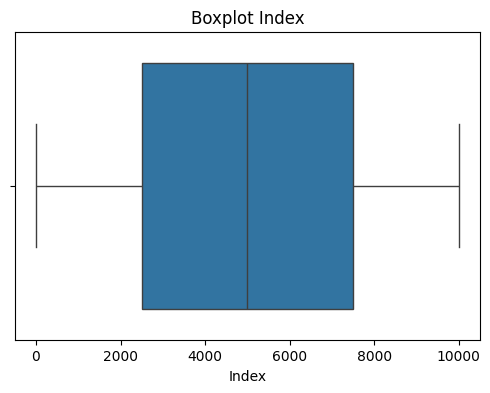

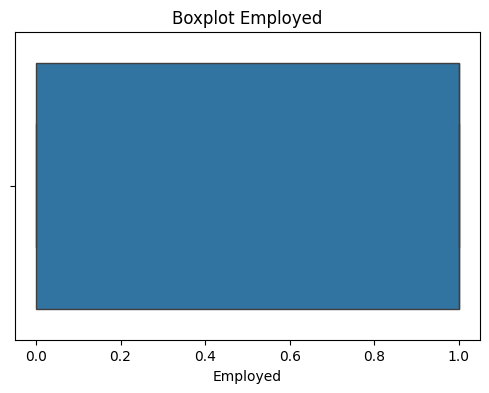

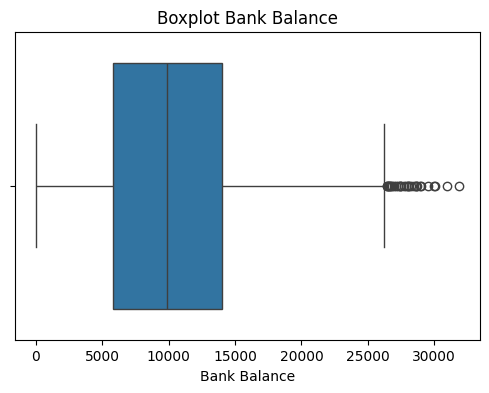

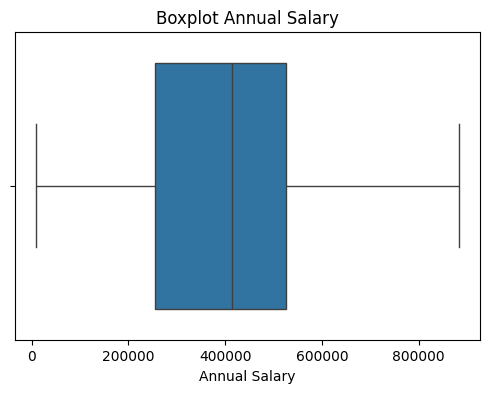

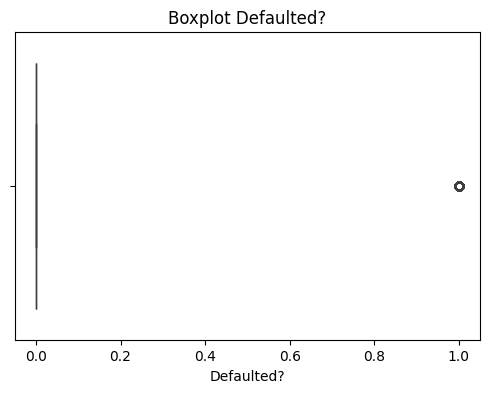

In [8]:
num_cols  = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
    plt.show()

###Penanganan Outliers

In [9]:
num_cols = num_cols.drop('Defaulted?')

In [10]:
# Hitung Q!, Q3 dan IQR hanya untuk kolom numerikal
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

In [11]:
# Buat filter untuk menghapus baris yang mengandung outlier di kolom numerikal
filters_outliers = ~((df[num_cols] < (Q1 - 1.0 * IQR)) |
                     (df[num_cols] > (Q3 + 1.0 * IQR))).any(axis=1)

In [12]:
# Terapkan filter ke dataset asli (termasuk kolom non-numerikal)
df = df[filters_outliers]

In [13]:
# Cek ukuran dataset setelah outliers dihapus
df.shape

(9751, 5)

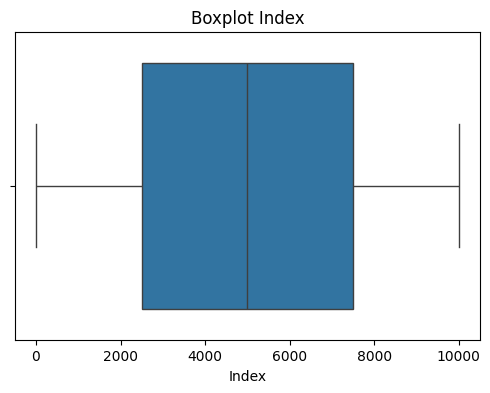

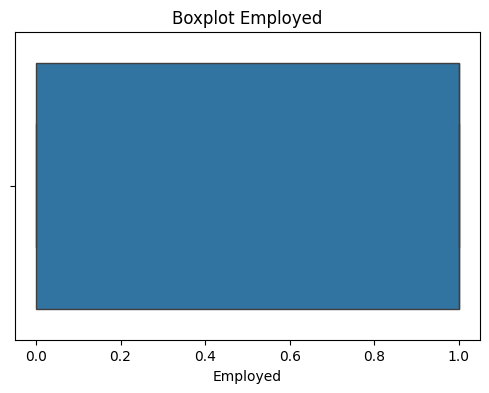

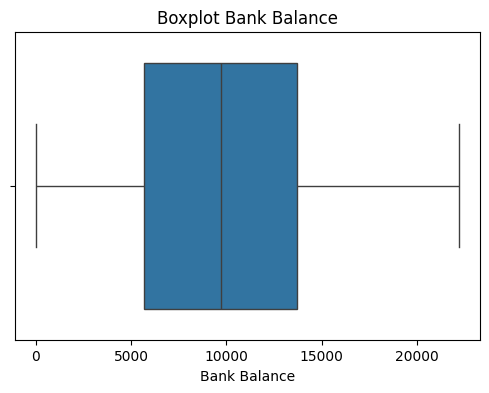

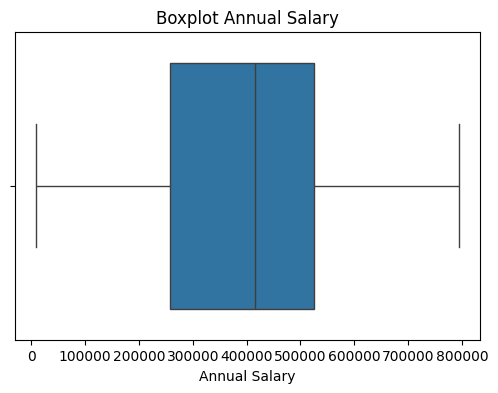

In [14]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
    plt.show()

## Penghapusan Fitur yang Tidak Relevan

In [15]:
df = df.drop(columns=['Index'])

##Visualisasi Distribusi

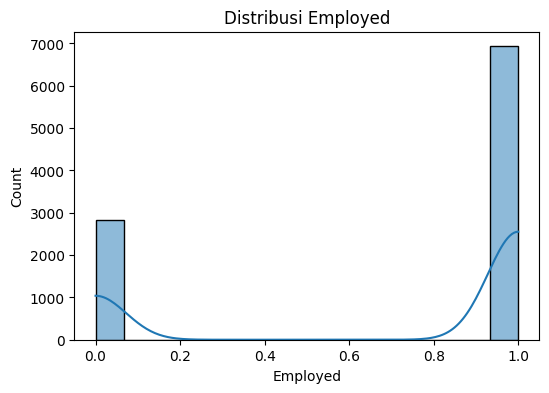

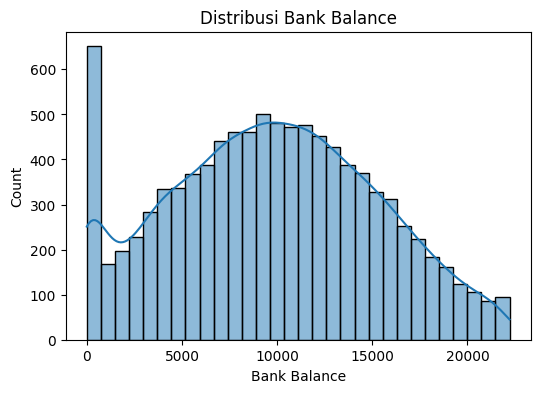

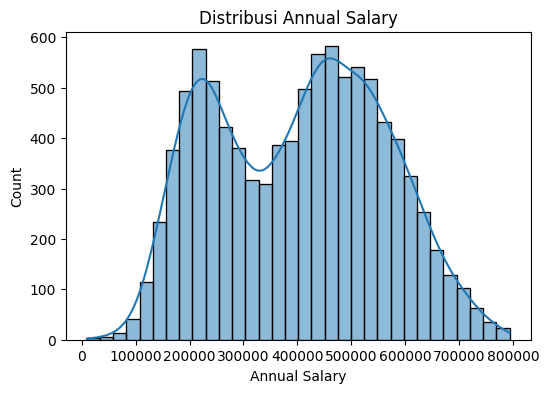

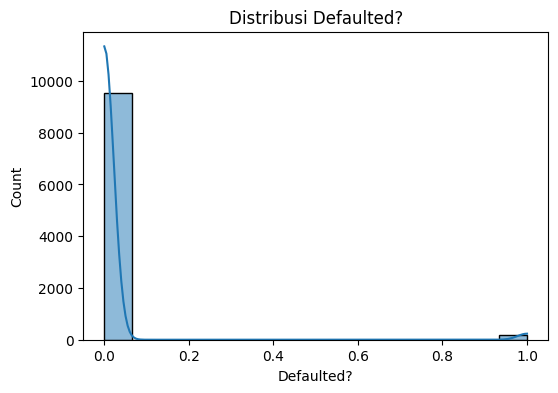

In [16]:
num_cols  = df.select_dtypes(include='number').columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.show()

##Coorelation Heatmap

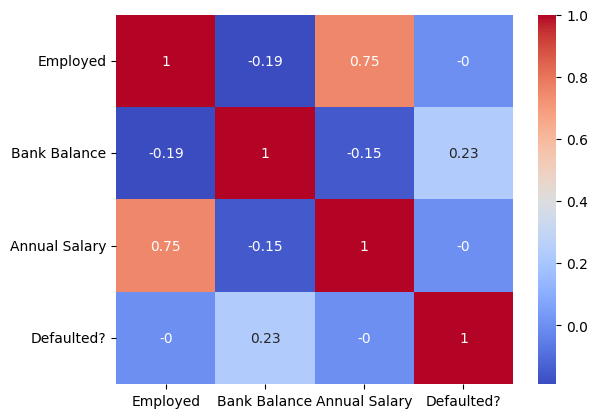

In [17]:
num_features = df.select_dtypes(include='number').columns.to_list()
cor = df[num_features].corr().round(2)
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

##Insight

* **Insight 1:** Mayoritas individu dalam dataset memiliki pekerjaan, dan kemungkinan gagal bayar lebih rendah pada individu yang bekerja.
* **Insight 2:** Saldo bank dan gaji tahunan tampaknya memiliki peran penting dalam menentukan kemungkinan gagal bayar.
* **Insight 3:** Dataset sangat tidak seimbang dari sisi target (`Defaulted?`), sehingga perlu penanganan khusus seperti resampling atau pemilihan metrik evaluasi yang tepat.

# **Data Preparation**

##Train-Test Split Data

In [18]:
X = df.drop('Defaulted?', axis=1)
y = df['Defaulted?']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
print("\n--- Distribusi Kelas Setelah Pembagian Data ---")
print("Distribusi kelas di Training Set:")
print(y_train.value_counts())
print(f"Proporsi kelas gagal bayar di Training Set: {y_train.value_counts(normalize=True)[1]:.2%}")
print("\nDistribusi kelas di Test Set:")
print(y_test.value_counts())
print(f"Proporsi kelas gagal bayar di Test Set: {y_test.value_counts(normalize=True)[1]:.2%}")


--- Distribusi Kelas Setelah Pembagian Data ---
Distribusi kelas di Training Set:
Defaulted?
0    7642
1     158
Name: count, dtype: int64
Proporsi kelas gagal bayar di Training Set: 2.03%

Distribusi kelas di Test Set:
Defaulted?
0    1912
1      39
Name: count, dtype: int64
Proporsi kelas gagal bayar di Test Set: 2.00%


##Resampling dengan SMOTEENN pada Training Set

In [21]:
sme = SMOTEENN(random_state=42)

X_train_resampled, y_train_resampled = sme.fit_resample(X_train, y_train)

print("Distribusi kelas di Training Set setelah SMOTEENN:")
print(y_train_resampled.value_counts())

Distribusi kelas di Training Set setelah SMOTEENN:
Defaulted?
0    6402
1    6396
Name: count, dtype: int64


##Standard Scaling

In [22]:
scaler = StandardScaler()

# Fit scaler hanya pada training set (yang sudah di-resample) dan transform.
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transform test set menggunakan scaler yang sama yang di-fit pada training set.
X_test_scaled = scaler.transform(X_test)

# Modeling

In [23]:
models = {
    "KNN" : KNeighborsClassifier(n_neighbors=15),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

results = {}

# Training & Evaluasi Model
for name, model in models.items():
    # Training
    model.fit(X_train_scaled, y_train_resampled)

    # Prediksi
    y_pred = model.predict(X_test_scaled)

    # Evaluasi
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Simpan hasil evaluasi
    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, zero_division=0)
    }

# Evaluation

In [24]:
# Tampilkan hasil evaluasi
for name, metrics in results.items():
    print(f"\n📌 Model: {name}")
    print(f"Accuracy       : {metrics['accuracy']:.4f}")
    print(f"Precision      : {metrics['precision']:.4f}")
    print(f"Recall         : {metrics['recall']:.4f}")
    print(f"F1 Score       : {metrics['f1_score']:.4f}")
    print("Confusion Matrix:\n", metrics['confusion_matrix'])
    print("Classification Report:\n", metrics['classification_report'])
    print("="*60)


📌 Model: KNN
Accuracy       : 0.8334
Precision      : 0.9776
Recall         : 0.8334
F1 Score       : 0.8926
Confusion Matrix:
 [[1594  318]
 [   7   32]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91      1912
           1       0.09      0.82      0.16        39

    accuracy                           0.83      1951
   macro avg       0.54      0.83      0.54      1951
weighted avg       0.98      0.83      0.89      1951


📌 Model: Random Forest
Accuracy       : 0.8616
Precision      : 0.9761
Recall         : 0.8616
F1 Score       : 0.9095
Confusion Matrix:
 [[1652  260]
 [  10   29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1912
           1       0.10      0.74      0.18        39

    accuracy                           0.86      1951
   macro avg       0.55      0.80      0.55      1951
weighted avg       0.98      0.